In [31]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid


In [32]:
data_dir = "mnistDataset/"
testDf = pd.read_csv(data_dir+"sign_mnist_test.csv")
trainDf = pd.read_csv(data_dir+"sign_mnist_train.csv")

In [33]:
def dataframe_to_nparray(train_df, test_df):
    train_df1 = train_df.copy(deep = True)
    test_df1 = test_df.copy(deep = True)
    train_images = train_df1.iloc[:, 1:].to_numpy(dtype = 'float32')
    test_images = test_df1.iloc[:, 1:].to_numpy(dtype = 'float32')
    return train_images,test_images

In [34]:
trainImage, testImage = dataframe_to_nparray(trainDf,testDf)
trainLabels = trainDf['label'].values
testLabels = testDf['label'].values

In [60]:
# ------- TRANSFORM INTO DATAFRAME -----------
trainImagesShaped = trainImage.reshape(trainImage.shape[0],1,28,28) 
testImagesShaped = testImage.reshape(testImage.shape[0],1,28,28) # 3 dimensional tensors

# ------- CONVERT INTO PYTORCH TENSORS -------
trainImageTensors = torch.from_numpy(trainImagesShaped)
trainLabelTensors = torch.from_numpy(trainLabels)
testImageTensors = torch.from_numpy(testImagesShaped)
testLabelTensors = torch.from_numpy(testLabels)
 
trainDataFull = TensorDataset(trainImageTensors, trainLabelTensors) # to be divided into train/validation
testData = TensorDataset(testImageTensors, testLabelTensors)

In [61]:
img, label = trainDataFull[0]
print(img.shape, label)

torch.Size([1, 28, 28]) tensor(3)


In [36]:
# ------- HYPER PARAMETERS and other constants -------
batch_size = 64
learning_rate = 0.001
in_channels = 1
input_size = in_channels * 28 * 28
num_classes = 26

In [37]:
# ------- CREATE TRAINING AND VALIDATION DATASET ----------
random_seed = 11
torch.manual_seed(random_seed);

val_size = 7455
train_size = len(trainDataFull)-val_size

trainData, valData = random_split(trainDataFull, [train_size, val_size]) # create validation set

In [63]:
trainDataLoader = DataLoader(trainData, batch_size, shuffle=True)
valDataLoader = DataLoader(valData, batch_size*2, num_workers=4, pin_memory=True)
testDataLoader = DataLoader(testData, batch_size*2, num_workers=4, pin_memory=True)

In [64]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# ------- CREATING NEURAL NETWORK ------
class CNN(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 256)
        # hidden layer 3
        self.linear3 = nn.Linear(256, 128)
        # output layer  
        self.linear4 = nn.Linear(128, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get inermediate outputs using hidden layer 3
        out = self.linear3(out)
        # Apply a activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [66]:
def evaluate(model, valueLoader):
    outputs = [model.validation_step(batch) for batch in valueLoader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, trainLoader, valueLoader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in trainLoader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model,valueLoader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [67]:
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [68]:
model = CNN(input_size, out_size = num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = to_device(model,device)


In [69]:
history = [evaluate(model, valData)]
history

[{'val_loss': 11.211682319641113, 'val_acc': 0.03898134082555771}]

In [70]:
history += fit(10, 0.001, model, trainData, valData)

Epoch [0], val_loss: 2.9397, val_acc: 0.2180
Epoch [1], val_loss: 1.3594, val_acc: 0.5537
Epoch [2], val_loss: 1.1234, val_acc: 0.6340
Epoch [3], val_loss: 0.6022, val_acc: 0.8303
Epoch [4], val_loss: 0.4660, val_acc: 0.8549
Epoch [5], val_loss: 0.3332, val_acc: 0.9142
Epoch [6], val_loss: 0.2536, val_acc: 0.9409
Epoch [7], val_loss: 0.1958, val_acc: 0.9517
Epoch [8], val_loss: 0.1248, val_acc: 0.9831
Epoch [9], val_loss: 0.0924, val_acc: 0.9885


Label: 6 , Predicted: 6


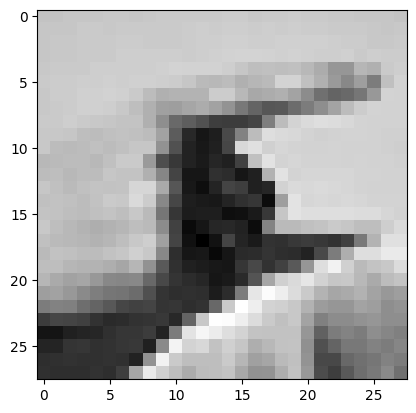

In [74]:
# ----------- PREDICTING IMAGES -------------
def predict_image(image, model):
    xb = to_device(image.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

image, label = testData[70]
plt.imshow(image.view(28,28),cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(image, model))